In [3]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport

In [4]:
%matplotlib inline
pd.set_option('display.max_columns', 55)

In [5]:
#read in csv
df = pd.read_csv("bigtable.csv")

In [6]:
df.head()

,datetime,pm25,type,sensor,station_id,x,y,population,dist-mroads,dist-setl,dist-coast,dist-forest,slope,elevation,dayofweek,sin_day,cos_day,sin_year,cos_year,TEMP,WIND,DEW,SKY,VIS,ATM,AQI_class,AQI_VALUE
0,2019-05-08 15:00:00+00:00,52.33,PurpleAir,B,14th & S ST NW B,38.913805,-77.03275,54.04969,0.072,-1.541,2.792,1.596,1.0,29.0,2,-0.707107,-7.071068e-01,0.806480,-0.591261,211.1,36.0,161.1,99999.0,16000.0,10218.1,USG,123.860000
1,2019-05-09 15:00:00+00:00,43.76,PurpleAir,B,14th & S ST NW B,38.913805,-77.03275,54.04969,0.072,-1.541,2.792,1.596,1.0,29.0,3,-0.707107,-7.071068e-01,0.796183,-0.605056,200.1,36.0,167.1,99999.0,16000.0,10213.1,USG,106.720000
2,2019-05-16 16:00:00+00:00,11.41,PurpleAir,B,14th & S ST NW B,38.913805,-77.03275,54.04969,0.072,-1.541,2.792,1.596,1.0,29.0,3,-0.866025,-5.000000e-01,0.717677,-0.696376,244.5,36.0,106.5,22000.0,16093.0,10131.5,Good,37.045455
3,2019-05-16 17:00:00+00:00,10.24,PurpleAir,B,14th & S ST NW B,38.913805,-77.03275,54.04969,0.072,-1.541,2.792,1.596,1.0,29.0,3,-0.965926,-2.588190e-01,0.717677,-0.696376,250.5,57.0,106.5,22000.0,16093.0,10126.5,Good,33.246753
4,2019-05-16 18:00:00+00:00,9.45,PurpleAir,B,14th & S ST NW B,38.913805,-77.03275,54.04969,0.072,-1.541,2.792,1.596,1.0,29.0,3,-1.000000,-1.836970e-16,0.717677,-0.696376,250.1,57.0,106.1,22000.0,16000.0,10126.1,Good,30.681818


In [7]:
df['type'].unique()

array(['PurpleAir', 'AirNow'], dtype=object)

In [8]:
df['datetime'].min()

'2019-01-01 00:00:00+00:00'

In [9]:
df['datetime'].max()

'2020-01-01 23:00:00+00:00'

In [10]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]#.astype(np.float64)

df = clean_dataset(df).reset_index()

features = df[[
    'population', 
    'dist-mroads', 
    'dist-setl', 
    'dist-coast', 
    'dist-forest', 
    'slope', 
    'elevation', 
    'dayofweek', 
    'sin_day', 
    'cos_day',
    'sin_year', 
    'cos_year', 
    'TEMP', 
    'WIND', 
    'DEW', 
    'SKY', 
    'VIS', 
    'ATM'
]].astype(np.float64)

gs = df[['station_id']]

y=df['pm25'].values
X=features

In [11]:
X.head()

,population,dist-mroads,dist-setl,dist-coast,dist-forest,slope,elevation,dayofweek,sin_day,cos_day,sin_year,cos_year,TEMP,WIND,DEW,SKY,VIS,ATM
0,54.04969,0.072,-1.541,2.792,1.596,1.0,29.0,2.0,-0.707107,-7.071068e-01,0.806480,-0.591261,211.1,36.0,161.1,99999.0,16000.0,10218.1
1,54.04969,0.072,-1.541,2.792,1.596,1.0,29.0,3.0,-0.707107,-7.071068e-01,0.796183,-0.605056,200.1,36.0,167.1,99999.0,16000.0,10213.1
2,54.04969,0.072,-1.541,2.792,1.596,1.0,29.0,3.0,-0.866025,-5.000000e-01,0.717677,-0.696376,244.5,36.0,106.5,22000.0,16093.0,10131.5
3,54.04969,0.072,-1.541,2.792,1.596,1.0,29.0,3.0,-0.965926,-2.588190e-01,0.717677,-0.696376,250.5,57.0,106.5,22000.0,16093.0,10126.5
4,54.04969,0.072,-1.541,2.792,1.596,1.0,29.0,3.0,-1.000000,-1.836970e-16,0.717677,-0.696376,250.1,57.0,106.1,22000.0,16000.0,10126.1


In [12]:
y

array([52.33, 43.76, 11.41, ...,  2.  ,  7.  ,  5.6 ])

In [13]:
df['AQI_class'].value_counts()

Good              76202
Moderate          19103
USG                1220
Unhealthy            73
Hazardous             9
Very unhealthy        5
Name: AQI_class, dtype: int64

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [21]:
visualizer = GradientBoostingRegressor()

visualizer.fit(X, y)  # Fit the training data to the visualizer
visualizer.predict(X)

array([11.86119646, 12.73707426, 10.39759421, ...,  8.04417286,
       10.13095973,  9.78339228])

## got the model to predict, figure out how to plot accuracy for continuous target using yellowbrick

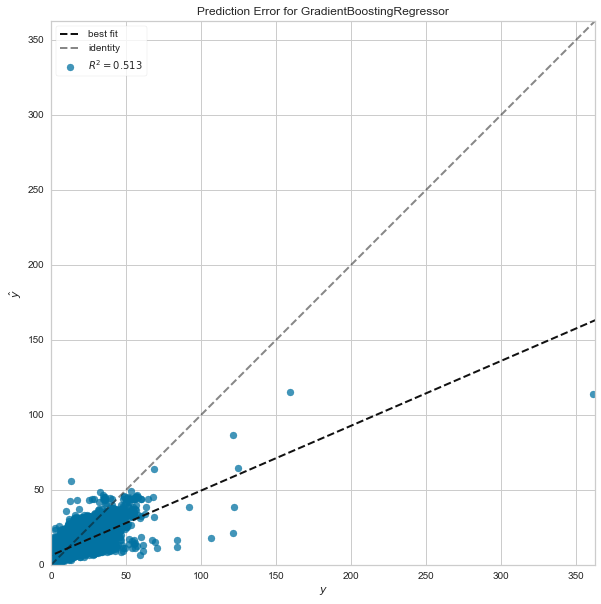

In [15]:
from sklearn.model_selection import train_test_split

from yellowbrick.regressor import PredictionError

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Instantiate the linear model and visualizer
model = GradientBoostingRegressor()
visualizer = PredictionError(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()